<a href="https://colab.research.google.com/github/pichu2707/recomendaciones/blob/main/Recomendaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistemas de recomendación para nuestra tienda, SaaS o cualquier otro menester

Un ecommerce o negocio puede optimizar sus compras si con ello personaliza los gustos lo máximo posible a los de sus usuarios. Para ello utilizaremos los datos que tenemos de las distintas comrpas para poder predecir que es lo que más le puede interesar.

### Importando librerías y DataSets

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357289 sha256=d15a6cca5c4f60145730fd9687a0d8d7a455ea55795b4f1139ba882a4fe5bfff
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold

## Importando DataSets

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Evento ENAE/tmdb_5000_credits.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Evento ENAE/tmdb_5000_movies.csv')

## Vamos a picar

In [ ]:
#Uniremos los dos DataFrames a través de la columna id
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')
df2.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


Vamos a necesitar una manera de puntuar las películas. Ordenar las películas según su puntuación y recomendar la mejor película valorada por los demás usuarios. Podemos también utilziar la calificación media de la película, el problema que tenemos aquí es que una película con una nota media de 8.9 t solo tres votos no pude considerarse mejor que una con 7.8 pero con 40. Por eso vamos a hacer uan calificación ponderada.

$$Weighted Rating(WR)=(\frac{v}{v+m}*R)+(\frac{m}{v+m}*C)$$

* R: Clasificación promedio del producto
* v: número de votos o calificaciones
* m: umbral o múnimo de votos necesarios para que un producto sea considerado de cálculo
* C: Clasificación promedio general de todos los productos de la base de datos

1. El peso de la calificación del producto $(\frac{m}{v+m}*C)$
Este término es el que más peso da a la calificación promedio del producto (R) cuando tiene un mayor número de votos (v). A medida que el número de votos aumenta, este término domina el cálculo.
2. El peso de la calificación base $(\frac{m}{v+m}*C)$:
Este término actua como un "suavizador" basado en la calificación promedio general (C). Tiene mayor peso cuando un producto tiene pocos votos (v)

In [ ]:
#Calculando el voto medio
C = df2['vote_average'].mean()
C

6.092171559442016

In [ ]:
#Vamos a calcular cual es mínimo de votos necesarios para la lista, en este caso utilizaremos un 90% de los últimos votos
m=df2['vote_count'].quantile(0.9)
m

1838.4000000000015

In [ ]:
#Ahora vamos a filtrar las películas que cumplen con los requisitos
q_movies=df2.copy().loc[df2['vote_count']>=m]
q_movies.shape

(481, 23)

Como vemos hay 481 películas que cumplen con los requisitos para estar en la lista. Ahora tenemos que calcular nuestra métrica para cada película. Para ello definimos una función weighted_ranting() y definiremos una nueva característica score, de la que calcularemos el valor aplicado a esta función a nuestro DataFrame de películas.

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    #Calculando basado en la fórmula de IMDB (Base de datos de películas en internet)
    return (v/(v+m)*R)+(m/(m+v)*C)

In [ ]:
#Definimos la nueva puntuación principal y calculamos su valor con la función de wieghted_rating()
q_movies['score']=q_movies.apply(weighted_rating, axis=1)

Por último, oordenamos el DataFrame en función de la puntuación que obtengamos, el recuento de votos, la media de votos y la puntuación ponderada de las 10 mejores películas

In [ ]:
#Ordenar las películas en función de la puntuación calculada anteriormente
q_movies=q_movies.sort_values('score',ascending=False)

#Pintar las 15 mejores películas
q_movies[['title','vote_count','vote_average','score']].head(15)


,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Ya tenemos nuestro primer recomendador. Sería como un sitema de "Son tendencia" donde encontramos películas que son muy populares y que simplemente se obtienen ordenando por la columnas de popularidad.

Text(0.5, 1.0, 'Películas más populares')

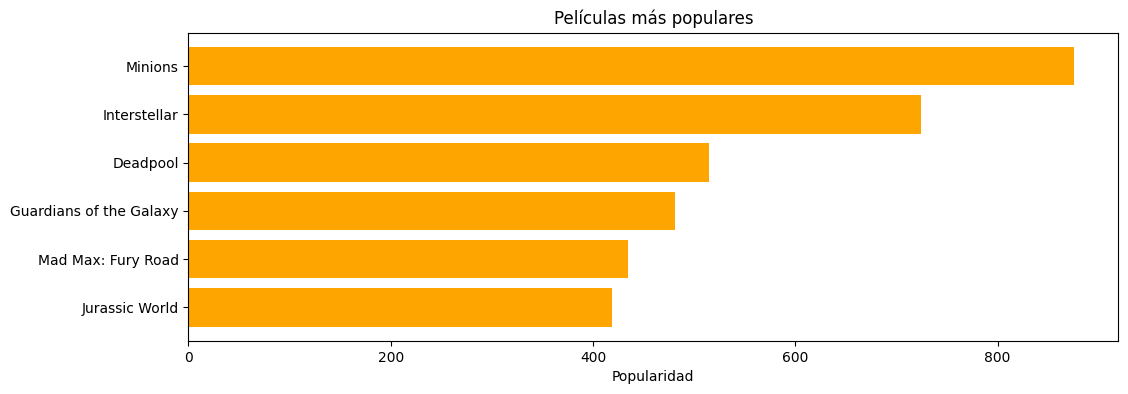

In [ ]:
#Creamos esas columna de popularidad
pop=df2.sort_values('popularity',ascending=False)
pop[['title','popularity']].head(10)
plt.figure(figsize=(12,4))
plt.barh(pop['title'].head(6),pop['popularity'].head(6),align='center',color='orange')
plt.gca().invert_yaxis()
plt.xlabel('Popularidad')
plt.title('Películas más populares')

Bien, vamos calentando motores, pero aún no es suficiente, tenemos estos recomndadores pero que no tiene en cuenta los datos demográficos. No son sensibles a los gustos de un usuario en particular. Vamos a filtrar basado en contenido

## Filtro por contenido

La recomendación basado en la descripción del argumento, calcularemos las puntuaciones de similitud opr pares de todas las películas basándonos en la descripción de sus argumentos y recomendaremos las películas en función de esa puntuación de similitud. Esta descripción la tenemos en los datos

In [ ]:
df2['overview'].head(5)

,overview
0,"In the 22nd century, a paraplegic Marine is di..."
1,"Captain Barbossa, long believed to be dead, ha..."
2,A cryptic message from Bond’s past sends him o...
3,Following the death of District Attorney Harve...
4,"John Carter is a war-weary, former military ca..."


Para resumir, haremos un procesamiento de los textos, pasándolos a vector de las palabras de cada resumen. Calcularemos los vcectores con el TF-IDF (Frecuencia de términos- Frecuencia inversa de documentos) de cada resumen.
El TF-IDF es la frecuencia de términos, se trata de una frecuencia relativa de una palabra en el documento.


In [ ]:
tfidf=TfidfVectorizer(stop_words='english')
df2['overview']=df2['overview'].fillna('')
tfidf_matrix=tfidf.fit_transform(df2['overview'])
tfidf_matrix.shape

(4803, 20978)

Tenemos 20000 palabras diferentes para escribir las 4800 películas que tiene nuestro dataset.
Con esa matriz en la mano podemos calculaar la puntuación de similitud. Hay varios métodos, la euclídea, de Pearson y la del coseno. No hay una respuesta correcta a qué puntuación es la mejor. Diferentes puntuaciones funcioann bien en diferentes escenarios y a menudo es bueno experimentar con las diferentes métricas.
Vamos a utilizar la de coseno porque es independiente de la magnitud y es relativamente fácil y rápida de calcular.
$$similarity=cos(\phi)=\frac{A.B}{\|A\|\|B\|}=\frac{\displaystyle\sum_{i=1}^{n} A_{i}B_{i}}{\sqrt{\sum_{i=1}^{n} A_{i}^2}\sqrt{\sum_{i=1}^{n} B_{i}^2}}$$

In [ ]:
cosine_sim=linear_kernel(tfidf_matrix,tfidf_matrix)

Vamos a definir una función que tome como entrada el título de una película y obtenga como salida una lista de las 10 películas más parecidas. Lo que necesitamos para esto es una correspondencia inversa entre los títulos y los índices del DataFrame.

In [ ]:
#Vamos a identificar el índice de nuesra película con el título que otorgamos
indices=pd.Series(df2.index, index=df2['title']).drop_duplicates()

Ahora que tenemos las condiciones para definir nuestra función esto es lo siguiente que haremos.
* Obtener el índice de la película dado su título
* Obtener la lista de puntuaciones de similitud de coseno de la película en concreto con todas las películas. Convertirla en una lista de tuplas donde el primer elemento es  su posición y el segundo es la puntuación de similitud
* Ordenar la lista de tuplas mencionadas en función de las puntuación de similitud.
* Obtener los 10 primeros elementos de la lista, ignoraremos el primero ya que será él mismo (la película que más se parece a una es la propia película).
* Devuelve los títulos correspondientes a los índices de los elementos superiores.

In [ ]:
def get_recommendations(title, cosine_sim=cosine_sim):
  idx=indices[title]
  sim_scores=list(enumerate(cosine_sim[idx]))
  sim_scores=sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores=sim_scores[1:11]
  movie_indices=[i[0] for i in sim_scores]
  return df2['title'].iloc[movie_indices]


In [ ]:
get_recommendations('The Dark Knight Rises')

,title
65,The Dark Knight
299,Batman Forever
428,Batman Returns
1359,Batman
3854,"Batman: The Dark Knight Returns, Part 2"
119,Batman Begins
2507,Slow Burn
9,Batman v Superman: Dawn of Justice
1181,JFK
210,Batman & Robin


In [ ]:
get_recommendations('The Avengers')

,title
7,Avengers: Age of Ultron
3144,Plastic
1715,Timecop
4124,This Thing of Ours
3311,Thank You for Smoking
3033,The Corruptor
588,Wall Street: Money Never Sleeps
2136,Team America: World Police
1468,The Fountain
1286,Snowpiercer


Tenemos un buen sistema, pero queremos mejorarlo, quizás no porque nos guste Batman como "Dark Knight Rises" el Caballero Oscuro, no tiene porque gustarte todas las películas de Batman (o si)

## Recomendaciones basados en créditos, géneros y palabras claves.
Vamos a mejorar un poquito más nuestro recomendador, y este podría mejorar con mejores metadatos. Vamos a crear el recomendador basado en los 3 actores principales, el director, los géneros relacionados y las palabras clave del argumento de la película.

A partir de las características de reparto, equipo y palabras clave, tenemos que extraer los actores, director y palabras clave de la película. Ahora mismo tenemos nuestros datos en listas hechas strings, tenemos que convertirlas en una estructura segura y utilizable.


In [ ]:
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [ ]:
#Obtenemos el nombre del director de la caraterística Crew. Si el director no aparece nos devuelve NaN
def get_director(x):
  for i in x:
    if i['job']=='Director':
      return i['name']
  return np.nan

In [ ]:
#Devuelve la lista de los top 3 elementos o entradas de lista o la lista completa dependiendo de que tenga más datos
def get_list(x):
  if isinstance(x,list):
    names=[i['name'] for i in x]

    #Miran a ver si existe más de tres elementos, si es que si devuelve únicamente los tres primeros elementos. si no devuelve la lista completa
    if len(names)>3:
      names=names[:3]
    return names
  #Devuelve la lista vacia en caso de faltar estar mal hecha
  return []

In [ ]:
#Define un director nuevo, reparto, genero y palabras clave características que se encuentran en una forma adecuada.
df2['director']=df2['crew'].apply(get_director)

features=['cast','keywords','genres']
for feature in features:
  df2[feature]=df2[feature].apply(get_list)

In [ ]:
#Imprime los nuevos datos clave de las 3 primeras películas
df2[['title','cast','director','keywords','genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


El siguiente paso sería convertir los nombres y las instancias de palabras clave en minúsculas y eliminar todos los espacios entre ellos. Esto se hace para que nuestro vectorizador no cuente el Jhonny de "Jhonny Depp" y "Jhonny Galecki" como el mismo.

In [ ]:
#La función convierte todo el string a minúsculas y corta los nombres en los espacios
def clean_data(x):
  if isinstance(x,list):
    return [str.lower(i.replace(" ","")) for i in x]
  else:
    #Revisa si el director existe. Si no devuevlve un string vacío
    if isinstance(x,str):
      return str.lower(x.replace(" ",""))
    else:
      return ''

In [ ]:
#Aplica la función clean_data en sus funciones.
features=['cast','keywords','director','genres']
for feature in features:
  df2[feature]=df2[feature].apply(clean_data)

Una cadena que contiene todos los datos metadatos que queremos introducir en nuestro vectorizador (es decir, actores, director y palabras clave)

In [ ]:
def create_soup(x):
  return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup']=df2.apply(create_soup,axis=1)

Los siguientes pasos son los mismos que hicimos con nuestro recomendador basado en la descripción de la trama. Una diferencia importante que tenemos CountVectorizer() en lugar del TF-IDF. Esto se debe a que no aplicamos la ponderación a la baja la presencia de un actor/director.

In [ ]:
#Importar el vector y crear un nuevo contador de matrices
count=CountVectorizer(stop_words='english')
count_matrix=count.fit_transform(df2['soup'])

In [ ]:
#Computa el coseno similar de la matriz basado en el count_matrix que hemos creado anteriormente
cosine_sim2=cosine_similarity(count_matrix,count_matrix)

In [ ]:
df2=df2.reset_index()
indices=pd.Series(df2.index, index=df2['title'])

Ahora podemos usar nuestra función get_recommendations() pasando la nueva matriz cosine_sim2 como segundo argumento

In [ ]:
get_recommendations('The Dark Knight Rises', cosine_sim2)


,title
65,The Dark Knight
119,Batman Begins
4638,Amidst the Devil's Wings
1196,The Prestige
3073,Romeo Is Bleeding
3326,Black November
1503,Takers
1986,Faster
303,Catwoman
747,Gangster Squad


In [ ]:
get_recommendations('The Godfather', cosine_sim2)

,title
867,The Godfather: Part III
2731,The Godfather: Part II
4638,Amidst the Devil's Wings
2649,The Son of No One
1525,Apocalypse Now
1018,The Cotton Club
1170,The Talented Mr. Ripley
1209,The Rainmaker
1394,Donnie Brasco
1850,Scarface


Bueno hemos ido mejorando nuiestro recomendador, ahora seguramente nos de mejores recomendacioens que al principio. Pero como friky seguramente me gusten las películas de Marvel o DC que producen (no todas). Por lo tanto, a nuestras características las podemos ampliar la promotora. Podemos aumentar el peso del director, añadiendo varias veces la característica a la "sopa"


## Filtrado colaborativo.

Nuestro motor está basado en el contenido que tiene como podemos comprobar algunas limitaciones graves. Sólo es capaz de sugerir películas cercanas a una determinada película. Es decir, no somos capaces de captar gustos y ofrecer recomendaciones para todos los géneros.

Además de esto el recomendador que hemos construido no es realmente pesonal, no capta los gustos o prejuicios del usuairo. Cualquiera que pida una recomendación sobre una película recibirá las mismas recomendaciones independientemente de quien sea.

Por lo tanto vamos a utilizar una técnica llamada "Filtrado Colaborativo" para hacer recomendaciones a los espectadores de películas. Basicamente se basa en dos tipos.

* Filtrado basado en el usuario: estos sistemas recomiendan a un usuairo productos que han gustado a usuarios similares. Para esto podemos usar la correlación de Pearson o la similitud del coseno.

* Filtrado basado en ítems: En lugar de medir entre usuarios, trabajaría según los ítems en función de la similitud con otros que el usuario valoró. Del mismo modo, la simitlitud puede calcularse también con la correlación de Pearson o la similitud de coseno.

Tenemos que tener cuidado también con estas formas de filtrar ya que si tenemos a alguien que puntúa por ejemplo Titanic y Spidemarn con la misma puntuación y no tienen nada que ver, al final nos la marca como si fueran similares y esto sería un problema.

## Descomposición del valor único
Una forma de resolver los problemas de escalabilidad que nos encotrábamos en el caso anterior y dispersión creados por los dos usuarios que han votado Titanic y Spiderman sería utilizar valores latentes para captar similitudes entre usuarios y artículos. Basicamente, queremos convertir el problema de recomendación en un problema de optimización.
Podemos verlo como el grado de acierto en la predición de valoración de un artículo dado por un usuario. Aquí la métrica que se suele usar es el error cuadrático medio (RMSE). Cuanto menor sea el RMSE, mejor será el rendimiento.

*El factor lantente, es una idea amplia que describe una propiedad o concepto que tiene un usuario o un elemento. Por ejemplo, el caso de la música puede referirse al género al que pertenece la música. La SVD (descomposición de valores singulares) reduce la dimensión de la matriz de utilidad extrayendo sus factores latentes.*

In [ ]:
"""
Cómo no tenemos un userID tenemos que crearlo, esto es necesario para el fitro colabolarivo, es por eso que usaremos la librería Surprise para implementar el SVD
"""

reader = Reader()
ratings = pd.read_csv('/content/drive/MyDrive/Evento ENAE/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
# Configuramos la validación cruzada con 5 folds
kf = KFold(n_splits=5)

In [ ]:
svd = SVD()
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8938  0.9006  0.8884  0.9008  0.8982  0.8963  0.0047  
MAE (testset)     0.6880  0.6942  0.6861  0.6910  0.6901  0.6899  0.0028  
Fit time          3.25    2.42    1.75    2.14    3.95    2.70    0.79    
Test time         0.75    0.22    0.11    0.22    0.39    0.34    0.22    


In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.587171656775268, details={'was_impossible': False})

Para la película con el ID 302, tenemos una predicción estimada de 2.618. Una característica sorprendente en un sistema de recomendación que no le importa que película es o que conteine. Funciona únicamente a partir de un ID de película asignado e intenta predecir las puntuaciones basado en cómo han predicho las películas los demás.